In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/MVA/graph_mlc/src


In [3]:
from util import *
from params import *
from imports import *

from data.dataset import *
from data.transforms import *

from model_zoo.common import *
from model_zoo.ggnn import *

from training.train import *
from training.freezing import *

In [4]:
seed_everything(SEED)

In [5]:
COMPUTE_A = False

# Datasets

In [6]:
trainval_dataset = MLCDataset(TRAINVAL_IMGS, 
                              transforms=get_transfos(size=IMG_SIZE),
                              img_path=IMG_PATH,
                              annotation_path=ANNOTATION_PATH
                             )

In [7]:
test_dataset = MLCDataset(TEST_IMGS, 
                          transforms=get_transfos(test=True, size=IMG_SIZE),
                          img_path=IMG_PATH,
                          annotation_path=ANNOTATION_PATH
                         )

# Visual Genome Relationship Graph

In [8]:
NB_KEPT_ITEMS = 300
NB_KEPT_PREDICATES = 100

In [9]:
CLASSES_ALIAS = [
        'airplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair',
        'cow', 'table', 'dog', 'horse',
        'motorcycle', 'person', 'plant',
        'sheep', 'couch', 'train',
        'tv'
        ]

In [10]:
def extract_relationships(data):
    objects = []
    predicates = []
    subjects = []
    for d in tqdm(data):
        for r in d['relationships']:
            predicates.append(r['predicate'].lower())
            try:
                objects.append(r['object']['name'])
            except:
                objects.append(r['object']['names'][0])
            try:
                subjects.append(r['subject']['name'])
            except:
                subjects.append(r['subject']['names'][0])
    return objects, predicates, subjects

In [11]:
if COMPUTE_A:
    with open(VISUAL_GENOME_PATH + 'relationships.json', 'r') as json_file:
        data = json.load(json_file)
        json_file.close
        
    objects, predicates, subjects = extract_relationships(data)
    
    count = Counter(objects + subjects)
    count_p = Counter(predicates)
    
    sorted_count = np.array(sorted(count.items(), key=operator.itemgetter(1)))[::-1]
    sorted_count_p = np.array(sorted(count_p.items(), key=operator.itemgetter(1)))[::-1]

In [12]:
if COMPUTE_A:
    kept_items = sorted_count[:NB_KEPT_ITEMS, 0]
    kept_items = CLASSES_ALIAS + [item for item in kept_items if item not in CLASSES_ALIAS]
    kept_items = kept_items[:NB_KEPT_ITEMS]
    
    kept_predicates = list(sorted_count_p[:NB_KEPT_PREDICATES, 0])

In [13]:
if COMPUTE_A:
    objects_new = []
    predicates_new = []
    subjects_new = []

    for o, p, s in tqdm(zip(objects, predicates, subjects)):
        if o in kept_items and s in kept_items and p in kept_predicates:
            objects_new.append(o)
            predicates_new.append(p)
            subjects_new.append(s)

In [14]:
if COMPUTE_A:
    A_in = np.zeros((NB_KEPT_PREDICATES, NB_KEPT_ITEMS, NB_KEPT_ITEMS), dtype=np.int32)
    A_out = np.zeros((NB_KEPT_PREDICATES, NB_KEPT_ITEMS, NB_KEPT_ITEMS), dtype=np.int32)

    for o, p, s in tqdm(zip(objects_new, predicates_new, subjects_new)):
        A_in[kept_predicates.index(p), kept_items.index(o), kept_items.index(s)] = 1
        A_out[kept_predicates.index(p), kept_items.index(s), kept_items.index(o)] = 1

In [15]:
if COMPUTE_A:
    np.save('../output/A_in.npy', A_in)
    np.save('../output/A_out.npy', A_out)
else:
    A_in = np.load('../output/A_in.npy')
    A_out = np.load('../output/A_out.npy')

In [16]:
A_in = A_in.mean(0, keepdims=True)
A_out = A_out.mean(0, keepdims=True)

In [17]:
P = 0.1
THRESHOLD = 0.1

In [18]:
A_in = A_in / A_in.max()
A_out = A_out / A_out.max()

In [19]:
A_in = threshold_and_reweight_matrix(A_in[0], t=THRESHOLD, p=P)[np.newaxis, :, :]
A_out = threshold_and_reweight_matrix(A_out[0], t=THRESHOLD, p=P)[np.newaxis, :, :]

# Train

In [20]:
def train_ggnn(backbone, train_dataset, val_dataset, 
                A_in, A_out, num_classes=20, use_ggnn=True,
                test_dataset=None, cp=False, model_name='model', threshold=0.5):
    
    seed_everything(SEED)
    
    model = GGNNClassifier(backbone, num_classes, A_in, A_out, ggnn_dim=10, time_steps=3, use_ggnn=use_ggnn).cuda()

    print('\n- Training logits only : ')

    freeze(model)
    for layer in ['out', 'ggnn', 'logits', 'bias_node']:
        unfreeze_layer(model, layer)

    n_parameters = count_parameters(model)
    print(f'    -> {n_parameters} trainable parameters\n')

    fit(model, train_dataset, val_dataset, epochs=3, batch_size=32, warmup_prop=0, lr=1e-3, min_lr=1e-4,
        verbose=1, verbose_eval=1, cp=False, model_name='model')

    print('\n- Training all layers: ')

    if backbone == 'resnet34':
        unfreeze(model)
    else:
        unfreeze_layer(model, 'layer4')
        
    n_parameters = count_parameters(model)
    print(f'    -> {n_parameters} trainable parameters\n')

    batch_size = 32 if IMG_SIZE == 224 else 8
    fit(model, train_dataset, val_dataset, epochs=5, batch_size=batch_size, warmup_prop=0, lr=1e-4, min_lr=1e-6,
        verbose=1, verbose_eval=1, cp=cp, model_name=model_name)

    print('\n- Evaluating: \n')

    if cp:
        load_model_weights(model, model_name, verbose=1)
        
    pred_val = predict_voc(model, val_dataset)
    print(f' - Scored {voc12_mAP(pred_val) :.3f} on validation data')
    aps = voc12_mAP(pred_val, return_aps=True)
    
    if test_dataset is not None:
        pred_test = predict_voc(model, test_dataset)
        print(f' - Scored {voc12_mAP(pred_test) :.3f} on test data\n')
    
    return model, aps

In [21]:
backbone = 'resnet34'
# backbone = 'resnet101'
# backbone = 'resnext101'

In [22]:
model, aps = train_ggnn(backbone, trainval_dataset, test_dataset, A_in, A_out, num_classes=NUM_CLASSES, model_name=backbone)


- Training logits only : 
    -> 221040 trainable parameters

Epoch 1/3 	 lr=1.0e-03 	 t=14s 	 loss=0.168 	 mAP=0.788 	 val_loss=0.104 	 
Epoch 2/3 	 lr=5.5e-04 	 t=14s 	 loss=0.112 	 mAP=0.811 	 val_loss=0.092 	 
Epoch 3/3 	 lr=1.0e-04 	 t=14s 	 loss=0.096 	 mAP=0.819 	 val_loss=0.088 	 

- Training all layers: 
    -> 21505712 trainable parameters

Epoch 1/5 	 lr=1.0e-04 	 t=20s 	 loss=0.097 	 mAP=0.844 	 val_loss=0.084 	 
Epoch 2/5 	 lr=8.6e-05 	 t=20s 	 loss=0.067 	 mAP=0.851 	 val_loss=0.084 	 
Epoch 3/5 	 lr=5.1e-05 	 t=20s 	 loss=0.049 	 mAP=0.862 	 val_loss=0.078 	 
Epoch 4/5 	 lr=1.5e-05 	 t=20s 	 loss=0.037 	 mAP=0.866 	 val_loss=0.076 	 
Epoch 5/5 	 lr=1.0e-06 	 t=20s 	 loss=0.033 	 mAP=0.866 	 val_loss=0.076 	 

- Evaluating: 

 - Scored 0.866 on validation data


In [23]:
# np.save('../output/aps_ggnn_resnet34_576.npy', np.array(aps))

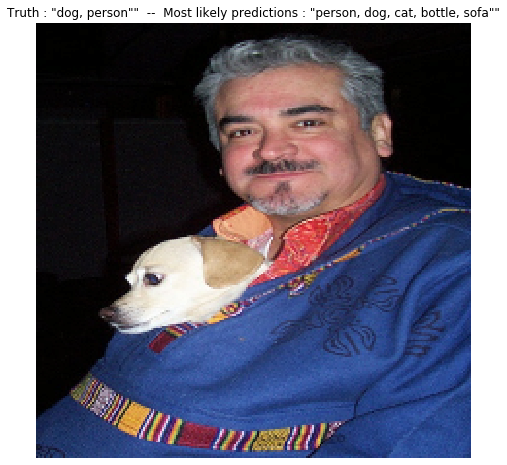

In [25]:
plot_results(model, test_dataset, n_plot=2)